<a href="https://colab.research.google.com/github/lookmeebbear/OpenRS_MIST2023/blob/main/MIST_Lookmee_Lab2_SDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Satellite Derived Bathymetry by Google Earth Engine and Single Beam Echo Sounder Sample Data, Case Study in Deepwater Port**

**Modern Integrated Survey Technique 2023**

Thepchai Srinoi

CU Survey Engineering for Non-Agriculture Research Unit

Department of Survey Engineering

Chulalongkorn University

______________________________________________________________________________

login เข้า google earth engine

In [1]:
import ee
# Authenticate to the Earth Engine servers
ee.Authenticate()
# Initialize the API
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=vsgpZpzab_MEeKM6b9bJ_gaspKeUyWsApv7hmZaink0&tc=fHr1iCZI-Vx5yf47q6j2tKza7KgzTpxyXZvb-8fjzF4&cc=LaHEEObXmgd9PiG_BJ2aKPOIeEai-KcFGghx42eJHdo

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh4QMRzSMbcdt7y8DBG0glZvKdkZcUm5Iow3Ol9CZCnGr5RTNhazfes

Successfully saved authorization token.


ลง library ที่จำเป็น

In [11]:
# import the crucial libraries
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import folium
import folium as fo

ฟังก์ชันที่เกี่ยวข้อง ฟังก์ชันกรองเมฆพร้อมคำนวณเลขใหม่ให้น้อยลง และ ฟังก์ชันแสดงแผนที่

In [3]:
# Install Function for Cloud Mask
def maskS2clouds(image) :
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (qa.bitwiseAnd(cloudBitMask).eq(0)) and (qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000)

# Map Visualization : Google Earth Engine
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

เปิดภาพแล้วแสดงภาพ

In [134]:
# Open the image
lat_min, lat_max, lon_min, lon_max =(12.6, 12.7, 101.1, 101.2)
AOI = ee.Geometry.Polygon(
        [[[lon_min, lat_max],
           [lon_min, lat_min],
           [lon_max, lat_min],
           [lon_max, lat_max]]])

fromdate = '2020-12-21'
todate = '2020-12-24'

image = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(fromdate,todate).\
          filterBounds(AOI).map(maskS2clouds).mosaic()

# Visualization
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=13)
map_matched.add_ee_layer(image,{'min':0, 'max':0.2, 'bands':['B4','B3','B2']},'RGB_L2A')
display(map_matched.add_child(folium.LayerControl()))

ดึงน้ำด้วยการใส่หน้ากากกับพื้นดินแบบง่ายๆ (band threshold)

In [135]:
B8_threshold = 0.1

B8_c = (image.select('B8').lt(B8_threshold)).selfMask()

B2_lm = image.select('B2').multiply(B8_c)
B3_lm = image.select('B3').multiply(B8_c)
B4_lm = image.select('B4').multiply(B8_c)
B8_lm = image.select('B8').multiply(B8_c)

image = image.addBands(B2_lm.rename('B2_lm'))
image = image.addBands(B3_lm.rename('B3_lm'))
image = image.addBands(B4_lm.rename('B4_lm'))
image = image.addBands(B8_lm.rename('B8_lm'))

folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=13)
map_matched.add_ee_layer(image,{'min':0, 'max':0.2, 'bands':['B4_lm','B3_lm','B2_lm']},'RGB_LM_L2A')
display(map_matched.add_child(folium.LayerControl()))

คำนวณ log ratio เห็นว่าค่าน้อยๆจะอยู่ริมชายฝั่ง ห่างออกไปค่าที่เพิ่มขึ้น ดังภาพ greyscale

In [136]:
nB2 = B2_lm.multiply(1000)
nB3 = B3_lm.multiply(1000)
logratio = (nB2.log()).divide(nB3.log())
image = image.addBands(logratio.rename('logratio'))
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=13)
map_matched.add_ee_layer(image,{'min':0, 'max':0.2, 'bands':['B4','B3','B2']},'RGB_L2A')
map_matched.add_ee_layer(image.select('logratio'),{'min':0.9, 'max':1.1},'logratio')
display(map_matched.add_child(folium.LayerControl()))

นำเข้าข้อมูลค่าระดับท้องน้ำ single beam echo sounding (ข้อมูลจาก คุณประจวบ เรียบร้อย Italianthai Development ภายใต้การติดต่อขอข้อมูลโดย รศ.ดร.ไพศาล สันติธรรมนนท์ Chulalongkorn University)

In [137]:
link = 'https://raw.githubusercontent.com/lookmeebbear/OpenRS_MIST2023/main/dataset1.csv'
df = pd.read_csv(link)
df

,lon,lat,E,N,H
0,101.139933,12.657334,732420.730,1400193.420,-4.200
1,101.139887,12.657608,732415.440,1400223.750,-4.130
2,101.139831,12.657763,732409.220,1400240.810,-3.590
3,101.139614,12.658080,732385.320,1400275.730,-2.630
4,101.139713,12.657956,732396.190,1400262.090,-2.520
...,...,...,...,...,...
517,101.139591,12.658313,732382.599,1400301.441,3.824
518,101.139577,12.658302,732381.135,1400300.227,2.439
519,101.139537,12.658381,732376.656,1400308.916,3.980
520,101.139518,12.658371,732374.681,1400307.886,2.854


แสดงข้อมูลตำแหน่งเก็บข้อมูลร่วมกับภาพถ่ายดาวเทียม

In [138]:
# Map Visualization : Sampling Point 
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=13)
latitudes = list(df.lat)
longitudes = list(df.lon)
for lat, lng in zip(latitudes, longitudes):
  fo.CircleMarker(location = [lat, lng], radius=3, color='red').add_to(map_matched)

map_matched.add_ee_layer(image,{'min':0, 'max':0.2, 'bands':['B4','B3','B2']},'RGB_L2A')
#map_matched.add_ee_layer(image.select('logratio'),{'min':0.9, 'max':1.1},'logratio')
display(map_matched.add_child(folium.LayerControl()))

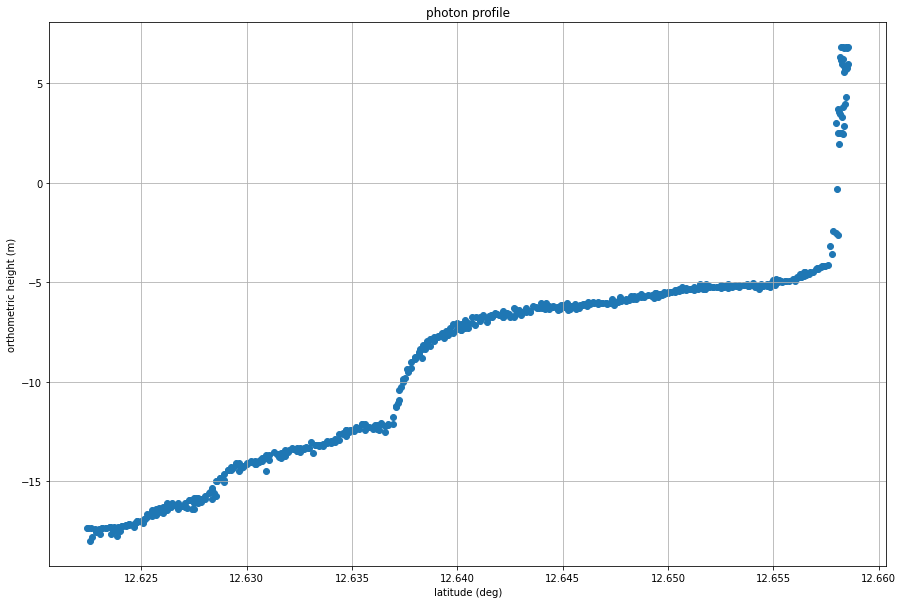

In [139]:
plt.rcParams['figure.figsize'] = [15, 10]
def depthplot(X,Y) :
  plt.title('photon profile')
  plt.ylabel('orthometric height (m)')
  plt.xlabel('latitude (deg)')
  #plt.scatter(df_train_select.lat,df_train_select.h)
  plt.scatter(X,Y)
  plt.grid()
  plt.show()
depthplot(df.lat, df.H)

เลือกเฉพาะที่เป็นท้องน้ำ

In [140]:
df = df.loc[df.H < 0]
df

,lon,lat,E,N,H
0,101.139933,12.657334,732420.73,1400193.42,-4.20
1,101.139887,12.657608,732415.44,1400223.75,-4.13
2,101.139831,12.657763,732409.22,1400240.81,-3.59
3,101.139614,12.658080,732385.32,1400275.73,-2.63
4,101.139713,12.657956,732396.19,1400262.09,-2.52
...,...,...,...,...,...
485,101.154040,12.622839,733984.97,1396388.99,-17.55
486,101.154042,12.622972,733984.97,1396403.70,-17.51
487,101.154283,12.622450,734011.64,1396346.16,-17.38
488,101.154136,12.622439,733995.75,1396344.79,-17.37


ดึง raster value (logratio) เข้า dataframe

In [141]:
def getvalue(vec) :

  lat,lng = vec
  u_poi = ee.Geometry.Point([lng,  	lat ])
  sdb_band = image.select('logratio')
  
  mydata_sdb = sdb_band.sample(u_poi, 10).getInfo()
  mylist_sdb = (mydata_sdb)['features']
  if mylist_sdb != [] :
      v = ((mylist_sdb[0])['properties'])['logratio']
  else :
      v = None

  return [v]

In [142]:
df['logratio'] = df[['lat', 'lon']].apply(getvalue, axis=1,  result_type ='expand')
df

<ipython-input-142-c79c61df0237>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['logratio'] = df[['lat', 'lon']].apply(getvalue, axis=1,  result_type ='expand')


,lon,lat,E,N,H,logratio
0,101.139933,12.657334,732420.73,1400193.42,-4.20,0.977954
1,101.139887,12.657608,732415.44,1400223.75,-4.13,0.982807
2,101.139831,12.657763,732409.22,1400240.81,-3.59,0.984303
3,101.139614,12.658080,732385.32,1400275.73,-2.63,0.993081
4,101.139713,12.657956,732396.19,1400262.09,-2.52,0.980345
...,...,...,...,...,...,...
485,101.154040,12.622839,733984.97,1396388.99,-17.55,1.047345
486,101.154042,12.622972,733984.97,1396403.70,-17.51,1.034064
487,101.154283,12.622450,734011.64,1396346.16,-17.38,1.045186
488,101.154136,12.622439,733995.75,1396344.79,-17.37,1.056895


คำนวณหา stumpf coefficient

Stumpf 0.7299309787490693 [147.60962556] -154.2232837126987


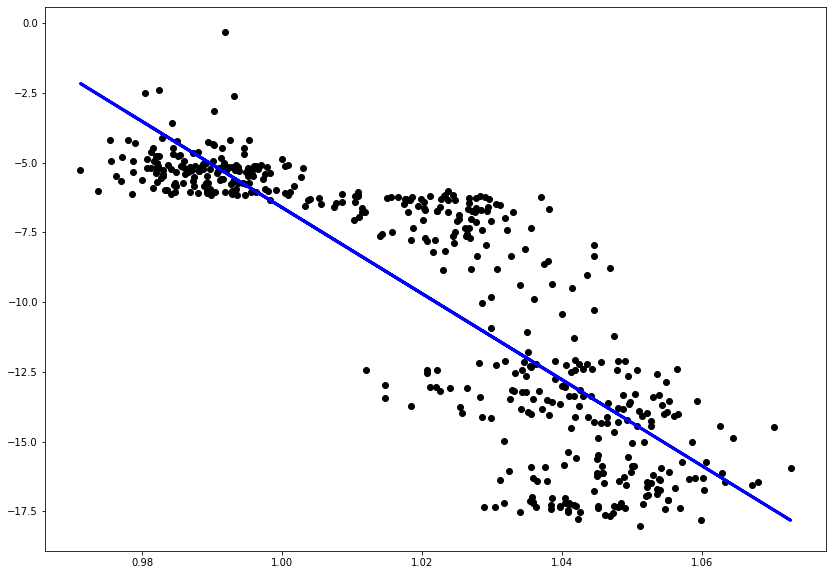

In [143]:
plt.rcParams['figure.figsize'] = [14, 10]

x_ST = (df[['logratio']].values).reshape((-1,1)) 
y = (df[['H']].values)
model_sdb_st = LinearRegression().fit(x_ST,y)

print('Stumpf', model_sdb_st.score(x_ST,y), model_sdb_st.intercept_, float(model_sdb_st.coef_) )

plt.scatter(x_ST, y, color = 'black')
plt.plot(x_ST, model_sdb_st.predict(x_ST), color = 'blue', linewidth = 3)
plt.show()

สร้างภาพ Satellite Derived Bathymetry

In [147]:
SDB_ST_Depth = ((image.select('logratio')).multiply(float(model_sdb_st.coef_))).add(float(model_sdb_st.intercept_))  
#SDB_ST = m0 + m1((ln1000B2)/(ln1000B3))
image = image.addBands(SDB_ST_Depth.rename('SDB'))
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=14)

depth_palette = ['blue','cyan', 'green','orange', 'red']

map_matched.add_ee_layer(image,{'min':0, 'max':0.3, 'bands':['B4','B3','B2']},'RGB_L2A')
map_matched.add_ee_layer(image,{'min':-25, 'max':0, 'bands':['SDB'], 'palette' : depth_palette},'h')

display(map_matched.add_child(folium.LayerControl()))

จบแล้วจ้า ไปเที่ยวทะเลกันเถอะ !!!!!!!!!!!

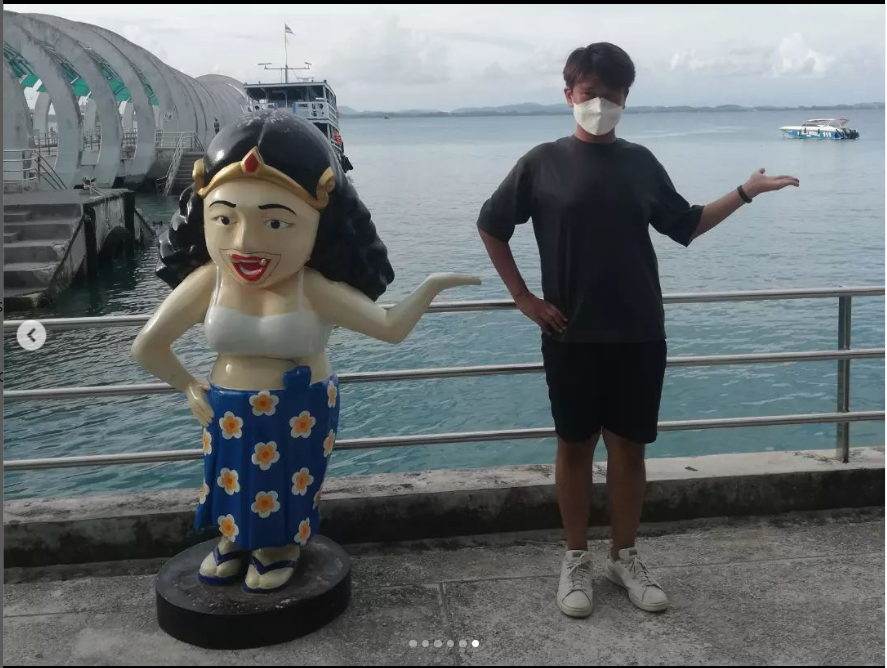